<a href="https://colab.research.google.com/github/vlamen/tue-deeplearning/blob/main/assignments/assignment2/workbook-A2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Preparation

In [1]:
# Install PyTorch Geometric
!pip install -q torch-scatter -f https://pytorch-geometric.com/whl/torch-1.8.0+cu101.html
!pip install -q torch-sparse -f https://pytorch-geometric.com/whl/torch-1.8.0+cu101.html
!pip install -q torch-geometric

In [2]:
import torch
import requests
import io
import pickle
import json

def download(url, filetype='tensor'):
    if filetype not in ['tensor', 'pickle', 'json']:
        raise ValueError('Incorrect filetype')
    response = requests.get(url)
    response.raise_for_status()
    if filetype == 'tensor':
        return torch.load(io.BytesIO(response.content))
    elif filetype == 'pickle':
        return pickle.load(io.BytesIO(response.content))
    elif filetype == 'json':
        return json.load(io.BytesIO(response.content))

# Task 1

In [3]:
## Download the dataset for image retrieval ##
data_1 = download('https://surfdrive.surf.nl/files/index.php/s/EH2tN7JiZnwdIXg/download', filetype='tensor')
data_metadata = download('https://github.com/pmernyei/wiki-cs-dataset/raw/master/dataset/metadata.json', filetype='json')

In [4]:
num_node = data_1.x.shape[0]
num_edge = data_1.edge_index.shape[1]
num_node_feature = data_1.x.shape[1]
num_class = int(max(data_1.y)+1)
num_label = sum(data_1.train_mask)

print(f'Num nodes: {num_node}')
print(f'Num edges: {num_edge}')
print()
print(f'Num node features: {num_node_feature}')
print(f'Num classes: {num_class}')
print()
print(f'Num training labels: {num_label}')

Num nodes: 10701
Num edges: 251927

Num node features: 300
Num classes: 10

Num training labels: 522


In [5]:
for i in range(num_class):
    print('{}: {}'.format(i, data_metadata['labels'][str(i)]))

0: Computational linguistics
1: Databases
2: Operating systems
3: Computer architecture
4: Computer security
5: Internet protocols
6: Computer file systems
7: Distributed computing architecture
8: Web technology
9: Programming language topics


In [6]:
def print_node(idx, url=True, label=True):
    node_info = data_metadata['nodes'][idx]
    print(f'--Node {idx}--')
    if url:
        title = node_info['title']
        wiki_url = 'https://en.wikipedia.org/wiki/' + title
        print(wiki_url)
    if label:
        print('Label:', node_info['label'])
    print()

In [7]:
for i in range(10):
    print_node(i)

--Node 0--
https://en.wikipedia.org/wiki/Twilio
Label: Distributed computing architecture

--Node 1--
https://en.wikipedia.org/wiki/Program_compatibility_date_range
Label: Operating systems

--Node 2--
https://en.wikipedia.org/wiki/SYSTAT_(DEC)
Label: Operating systems

--Node 3--
https://en.wikipedia.org/wiki/List_of_column-oriented_DBMSes
Label: Databases

--Node 4--
https://en.wikipedia.org/wiki/Stealth_wallpaper
Label: Computer security

--Node 5--
https://en.wikipedia.org/wiki/Scalable_TCP
Label: Internet protocols

--Node 6--
https://en.wikipedia.org/wiki/Carrier_IQ
Label: Computer security

--Node 7--
https://en.wikipedia.org/wiki/ACF2
Label: Operating systems

--Node 8--
https://en.wikipedia.org/wiki/Dorkbot_(malware)
Label: Computer security

--Node 9--
https://en.wikipedia.org/wiki/Lout_(software)
Label: Programming language topics



In [8]:
from torch_geometric.nn import SAGEConv, GCNConv, GATConv, ClusterGCNConv
from torch import nn
import torch.nn.functional as F

class GraphSAGE(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = SAGEConv(300, 32) # Embeddings to 32 channels
        self.conv2 = SAGEConv(32, 10) # Predict one of 10 classes

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index) # Update all nodes
        x = F.dropout(x.relu(), p=0.75, training=self.training) # Apply ReLU activation and dropout
        x = self.conv2(x, edge_index) # Update all nodes and predict their classes
        return x

In [9]:
# Obtain GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Create a dictionary of nodes and their neighbors
neighbors = {i: [False] * num_node for i in range(num_node)}
for v1, v2 in data_1.edge_index.permute(1, 0).tolist():
    neighbors[v1][v2] = True
    neighbors[v2][v1] = True
for k,v in neighbors.items():
    neighbors[k] = torch.tensor(v).to(device)

In [10]:
import random
from statistics import mean
import numpy as np

def compute_stats(nodes, neighbors, y_pred, y_true, ignore_misclassified_query=False):
    # Iterate over all nodes in the test set with their predicted and true labels
    for node, pred, true in zip(nodes, y_pred, y_true):
        if not ignore_misclassified_query or pred == true:
            # Determine the predicted and true sets of similar articles
            predicted_articles = (y_pred == pred)[neighbors[node]].nonzero().cpu()
            true_articles = (y_true == true)[neighbors[node]].nonzero().cpu()
            # Determine true positives
            tp = np.intersect1d(predicted_articles, true_articles)
            # Compute and return precision and recall
            precision = (len(tp) / len(predicted_articles)) if len(predicted_articles) else (0 if len(tp) else 1)
            recall = (len(tp) / len(true_articles)) if len(true_articles) else (0 if len(tp) else 1)
            yield precision, recall

def fit(epochs, model, loss_func, opt, data):
    tl, ta, vl, va, prec, rec = [], [], [], [], [], [] # Initialize lists of statistics
    test_neighbors = {k: v[data.test_mask] for k, v in neighbors.items()} # Create the neighbor mapping for the test set
    for epoch in range(1, epochs+1):
        model.train() # Train
        opt.zero_grad() # Zero out the gradients
        out = model(data.x, data.edge_index) # Obtain classifications
        loss = loss_func(out[data.train_mask], data.y[data.train_mask]) # Compute loss
        loss.backward() # Compute gradients
        opt.step() # Update the model
        tl.append(loss.item()) # Store loss
        train_correct = out.argmax(dim=1)[data.train_mask] == data.y[data.train_mask] # Count correct predictions
        ta.append(int(train_correct.sum()) / int(data.train_mask.sum())) # Compute and store accuracy
        model.eval() # Test
        out = model(data.x, data.edge_index) # Obtain classifications
        loss = loss_func(out[data.test_mask], data.y[data.test_mask]) # Compute loss
        vl.append(loss.item()) # Store loss
        test_correct = out.argmax(dim=1)[data.test_mask] == data.y[data.test_mask] # Count correct predictions
        va.append(int(test_correct.sum()) / int(data.test_mask.sum())) # Compute and store accuracy
        stats = list(compute_stats(data.test_mask.nonzero().flatten().tolist(), test_neighbors, out.argmax(dim=1)[data.test_mask], data.y[data.test_mask], ignore_misclassified_query=False)) # Compute precision and recall
        prec.append(mean(x[0] for x in stats)) # Store average precision
        rec.append(mean(x[1] for x in stats)) # Store average recall
        print(f'\rEpoch {epoch}/{epochs}, Tr. loss: {str(tl[-1])[:6]}, Tr. acc: {str(ta[-1])[:6]}, Val. loss: {str(vl[-1])[:6]}, Val. acc.: {str(va[-1])[:6]}, Prec.: {str(prec[-1])[:6]}, Rec.: {str(rec[-1])[:6]}')
    return tl, ta, vl, va, prec, rec

model = GraphSAGE().to(device)
loss_func = torch.nn.CrossEntropyLoss() # Typical classification task
opt = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4) # Usually works well
data = data_1.to(device)

train_loss, train_acc, test_loss, test_acc, precision, recall = fit(100, model, loss_func, opt, data)

Epoch 1/100, Tr. loss: 2.3468, Tr. acc: 0.0651, Val. loss: 2.1902, Val. acc.: 0.2870, Prec.: 0.7713, Rec.: 0.7371
Epoch 2/100, Tr. loss: 2.2100, Tr. acc: 0.1819, Val. loss: 2.0471, Val. acc.: 0.2701, Prec.: 0.6889, Rec.: 0.9728
Epoch 3/100, Tr. loss: 2.0734, Tr. acc: 0.2758, Val. loss: 1.9374, Val. acc.: 0.3315, Prec.: 0.6990, Rec.: 0.9382
Epoch 4/100, Tr. loss: 1.9835, Tr. acc: 0.3256, Val. loss: 1.8579, Val. acc.: 0.4835, Prec.: 0.7457, Rec.: 0.8119
Epoch 5/100, Tr. loss: 1.9070, Tr. acc: 0.3486, Val. loss: 1.7889, Val. acc.: 0.5130, Prec.: 0.7548, Rec.: 0.8143
Epoch 6/100, Tr. loss: 1.8494, Tr. acc: 0.3946, Val. loss: 1.7171, Val. acc.: 0.5379, Prec.: 0.7603, Rec.: 0.8322
Epoch 7/100, Tr. loss: 1.7927, Tr. acc: 0.4233, Val. loss: 1.6427, Val. acc.: 0.5605, Prec.: 0.7668, Rec.: 0.8527
Epoch 8/100, Tr. loss: 1.7199, Tr. acc: 0.4329, Val. loss: 1.5711, Val. acc.: 0.5706, Prec.: 0.7705, Rec.: 0.8578
Epoch 9/100, Tr. loss: 1.6170, Tr. acc: 0.4750, Val. loss: 1.5016, Val. acc.: 0.5755, Pr

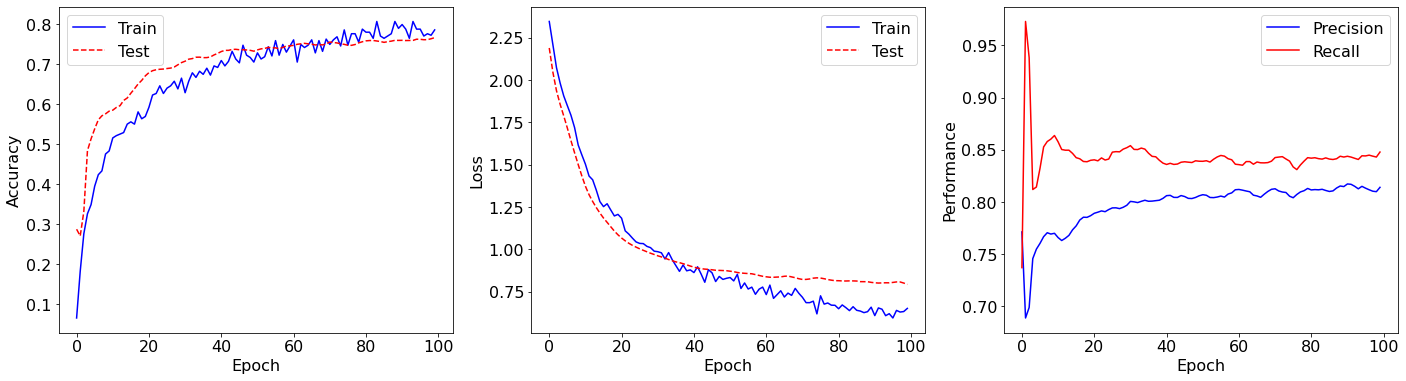

In [11]:
%matplotlib inline
import matplotlib.pyplot as plt

# Plot training and evaluation metrics
fig, ax = plt.subplots(1, 3, figsize=(24,6))
fnt=16
ax[0].plot(train_acc, color='blue', label='Train')
ax[0].plot(test_acc, color='red', linestyle='--', label='Test')
ax[0].legend(fontsize=fnt)
ax[0].tick_params(axis='both', labelsize=fnt)
ax[0].set_xlabel('Epoch', fontsize=fnt)
ax[0].set_ylabel('Accuracy', fontsize=fnt)
ax[1].plot(train_loss, color='blue', label='Train')
ax[1].plot(test_loss, color='red', linestyle='--', label='Test')
ax[1].legend(fontsize=fnt)
ax[1].tick_params(axis='both', labelsize=fnt)
ax[1].set_xlabel("Epoch", fontsize=fnt)
ax[1].set_ylabel("Loss", fontsize=fnt);
ax[2].plot(precision, color='blue', label='Precision')
ax[2].plot(recall, color='red', label='Recall')
ax[2].legend(fontsize=fnt)
ax[2].tick_params(axis='both', labelsize=fnt)
ax[2].set_xlabel("Epoch", fontsize=fnt)
ax[2].set_ylabel("Performance", fontsize=fnt);

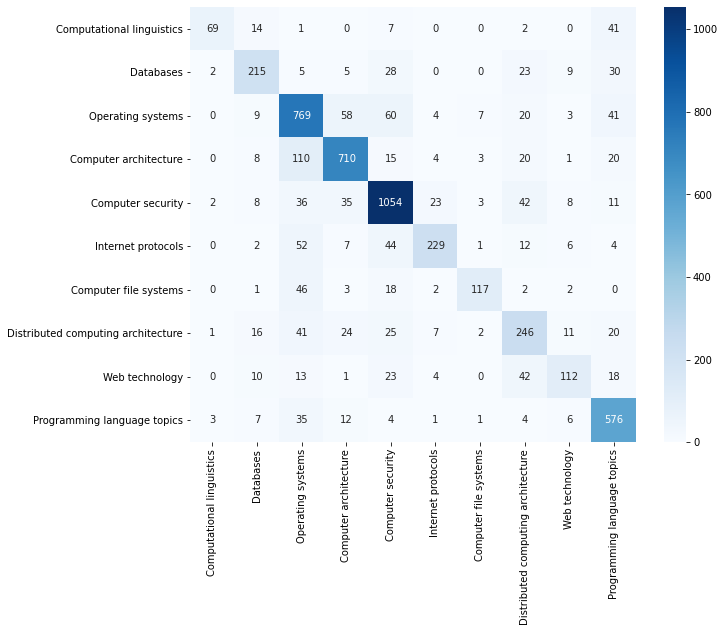

In [12]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns

# Obtain predicted and true classifications
out = model(data.x, data.edge_index)
y_true = data.y[data.test_mask].cpu().numpy().reshape(-1)
y_pred = out.argmax(dim=1)[data.test_mask].cpu().numpy().reshape(-1)

# Plot the classifications in confusion matrix
cm = confusion_matrix(y_true, y_pred)
f, ax = plt.subplots(1,1,figsize=(10,8))
sns.heatmap(cm, annot=True, ax = ax, cmap='Blues', fmt="d", xticklabels=data_metadata['labels'].values(), yticklabels=data_metadata['labels'].values());

In [13]:
# Retrieval

def retrieve(idx):
    y_pred = model(data.x, data.edge_index).argmax(dim=1) # Obtain classifications
    pred = y_pred[idx] # Get classification of given node
    pred_idx = (pred == y_pred)[neighbors[idx]].nonzero().flatten().tolist() # Determine the predicted set of similar articles
    # Print result
    print('Query article:')
    title = data_metadata['nodes'][idx]['title']
    print(f'https://en.wikipedia.org/wiki/{title}\n')
    for node in pred_idx:
        print('Similar article:')
        title = data_metadata['nodes'][node]['title']
        print(f'https://en.wikipedia.org/wiki/{title}\n')

retrieve(42)

Query article:
https://en.wikipedia.org/wiki/Crypto_cloud_computing

Similar article:
https://en.wikipedia.org/wiki/Twilio

Similar article:
https://en.wikipedia.org/wiki/Program_compatibility_date_range



# Task 2

In [14]:
# GraphSAGE-based encoder architecture
class Encoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = SAGEConv(300, 32) # Shared layer with 32 filters
        self.conv_mu = SAGEConv(32, 24) # Get mu with latent space dimension 24
        self.conv_sigma = SAGEConv(32, 24) # Get log sigma with latent space dimension 24
        
    def forward(self, x, edge_index):
        h = self.conv(x, edge_index) # Update all nodes
        h = h.relu() # ReLU activation for the shared layer
        mu = self.conv_mu(h, edge_index) # Obtain mu
        log_sigma = self.conv_sigma(h, edge_index) # Obtain log sigma
        z = self.reparameterise(mu, log_sigma) # Obtain z from mu and log sigma
        return mu, log_sigma, z
    
    def reparameterise(self, mu, log_sigma):
        sigma = torch.exp(log_sigma) # Compute sigma
        epsilon = torch.rand_like(sigma).to(device) # Sample from normal distribution
        return mu + sigma * epsilon # Compute z

# GraphSAGE-based decoder architecture
class Decoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = SAGEConv(24, 32) # Latent variables to 32 channels
        self.conv_out = SAGEConv(32, 300) # Get mu with input dimension
        
    def forward(self, x, edge_index):
        h = self.conv(x, edge_index) # Update all nodes
        h = h.relu() # Apply ReLU activation
        x_recon = self.conv_out(h, edge_index) # Obtain mu, representing reconstructed articles
        return x_recon

# VAE architecture
class VAE(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = Encoder() # GraphSAGE-based encoder
        self.decoder = Decoder() # GraphSAGE-based decoder
                
    def forward(self, x, edge_index):
        mu, log_sigma, z = self.encoder(x, edge_index) # Obtain parameters and latent variables from input
        x_recon = self.decoder(z, edge_index) # Obtain reconstructed articles from latent variables
        return mu, log_sigma, x_recon

In [15]:
def train(epochs, model, loss_func, opt, data):
    l, rl, kll = [], [], [] # Initialize lists of statistics
    model.train() # Train
    x_len = len(data.x) # Obtain total number of articles
    for epoch in range(1, epochs+1):
        opt.zero_grad() # Zero out the gradients
        loss, recon_loss, kl_loss = loss_func(data.x, *model(data.x, data.edge_index)) # Compute loss terms
        l.append(loss.item() / x_len) # Store average loss
        rl.append(recon_loss.item() / x_len) # Store average reconstruction loss
        kll.append(kl_loss.item() / x_len) # Store average KL loss
        loss.backward() # Compute gradients
        opt.step() # Update the model
        print(f'\rEpoch {epoch}/{epochs}, Loss: {str(l[-1])[:6]}, Rec. loss: {str(rl[-1])[:6]}, KL loss: {str(kll[-1])[:6]}')
    return l, rl, kll
  
def loss_func(x, mu, log_sigma, x_recon):
    recon_loss = nn.functional.mse_loss(x_recon, x, reduction='sum') # Skip second term and assume sigma = 1/sqrt(2) to compute reconstruction loss
    kl_loss = 0.5 * torch.sum(mu.pow(2) + (2*log_sigma).exp() - 2*log_sigma - 1) # Compute KL divergence
    return recon_loss + kl_loss, recon_loss, kl_loss
  
vae = VAE().to(device)
opt = torch.optim.Adam(vae.parameters(), lr=1e-3) # Usually works well
data = data_1.to(device)

losses, rec_losses, kl_losses = train(200, vae, loss_func, opt, data)

Epoch 1/200, Loss: 31.874, Rec. loss: 31.269, KL loss: 0.6045
Epoch 2/200, Loss: 27.509, Rec. loss: 26.960, KL loss: 0.5489
Epoch 3/200, Loss: 23.886, Rec. loss: 23.361, KL loss: 0.5245
Epoch 4/200, Loss: 21.008, Rec. loss: 20.474, KL loss: 0.5339
Epoch 5/200, Loss: 18.703, Rec. loss: 18.124, KL loss: 0.5789
Epoch 6/200, Loss: 16.881, Rec. loss: 16.223, KL loss: 0.6584
Epoch 7/200, Loss: 15.427, Rec. loss: 14.660, KL loss: 0.7663
Epoch 8/200, Loss: 14.426, Rec. loss: 13.534, KL loss: 0.8915
Epoch 9/200, Loss: 13.692, Rec. loss: 12.677, KL loss: 1.0154
Epoch 10/200, Loss: 13.161, Rec. loss: 12.045, KL loss: 1.1168
Epoch 11/200, Loss: 12.745, Rec. loss: 11.561, KL loss: 1.1841
Epoch 12/200, Loss: 12.388, Rec. loss: 11.177, KL loss: 1.2110
Epoch 13/200, Loss: 12.045, Rec. loss: 10.847, KL loss: 1.1976
Epoch 14/200, Loss: 11.718, Rec. loss: 10.566, KL loss: 1.1522
Epoch 15/200, Loss: 11.408, Rec. loss: 10.325, KL loss: 1.0835
Epoch 16/200, Loss: 11.111, Rec. loss: 10.112, KL loss: 0.9993
E

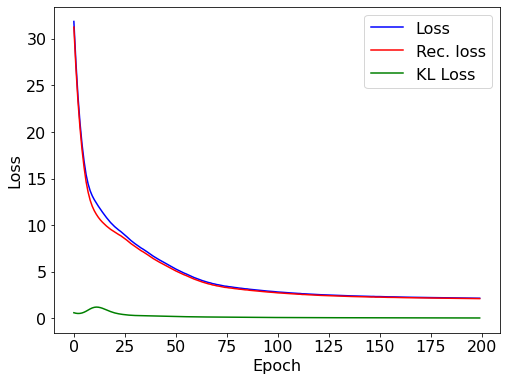

In [16]:
%matplotlib inline
import matplotlib.pyplot as plt

# Plot training and evaluation metrics
fig, ax = plt.subplots(1, 1, figsize=(8,6))
fnt=16
ax.plot(losses, color='blue', label='Loss')
ax.plot(rec_losses, color='red', label='Rec. loss')
ax.plot(kl_losses, color='green', label='KL Loss')
ax.legend(fontsize=fnt)
ax.tick_params(axis='both', labelsize=fnt)
ax.set_xlabel("Epoch", fontsize=fnt)
ax.set_ylabel("Loss", fontsize=fnt);

In [17]:
## Download the anomaly evaluation data ##
data_2 = download('https://surfdrive.surf.nl/files/index.php/s/EzMkh3SZbsbJb2i/download', filetype='tensor')
is_anomaly = download('https://surfdrive.surf.nl/files/index.php/s/wrK5xipcIC9DHhu/download', filetype='pickle')

In [18]:
total_node = data_2.x.shape[0]
total_edge = data_2.edge_index.shape[1]
new_node = total_node - num_node
new_edge = total_edge - num_edge
print(f'Num new nodes: {new_node}')
print(f'Num new edges: {new_edge}')

Num new nodes: 2000
Num new edges: 50176


In [19]:
print(f'Indices of new nodes are {num_node}...{total_node-1}')
print('The first 1000 are real articles, the last 1000 are anomaly articles')
print('You can use the map "is_anomaly" to identify whether a node is an anomaly or not')
e_real = num_node+500
e_anomaly = num_node+1500
print(f'E.g., is_anomaly[{e_real}] = {is_anomaly[e_real]} and is_anomaly[{e_anomaly}] = {is_anomaly[e_anomaly]}')

Indices of new nodes are 10701...12700
The first 1000 are real articles, the last 1000 are anomaly articles
You can use the map "is_anomaly" to identify whether a node is an anomaly or not
E.g., is_anomaly[11201] = 0 and is_anomaly[12201] = 1


In [20]:
def eval(model, elbo_func, data):
    # Initialize lists of ELBO values
    ln, la = [], []
    # Evaluate
    model.eval()
    with torch.no_grad():
        # Obtain ELBO values for all articles
        elbos = elbo_func(data.x, *model(data.x, data.edge_index)).cpu().numpy()
        # Store the ELBO values of all normal and anomalous articles
        for idx, anomalous in is_anomaly.items():
            if anomalous:
                la.append(elbos[idx])
            else:
                ln.append(elbos[idx])
    return np.array(ln), np.array(la)

def elbo(x, mu, log_sigma, x_recon):
    recon_loss = torch.sum(nn.functional.mse_loss(x_recon, x, reduction='none'), dim=1) # Obtain values for each data point
    const_term = 300 * 0.5 * np.log(np.pi)  # Restore constant term by assuming sigma = 1/sqrt(2)
    kl_loss = 0.5 * torch.sum(mu.pow(2) + (2*log_sigma).exp() - 2*log_sigma - 1, dim=1) # Obtain values for each data point
    return - (recon_loss + kl_loss + const_term)

normal_elbos, anomalous_elbos = eval(vae, elbo, data_2.to(device)) # Obtain negative ELBO values for evaluation set

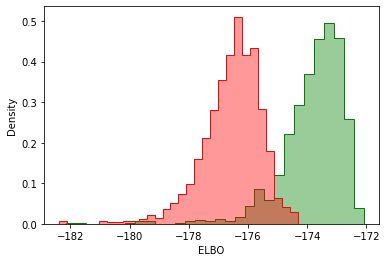

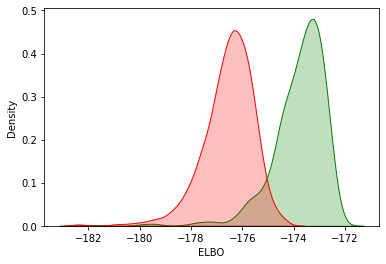

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot histogram of ELBO values
plt.figure()
plt.hist(normal_elbos, bins=30, density=True, histtype="bar", color="g", alpha=0.4)
plt.hist(normal_elbos, bins=30, density=True, histtype="step", color="g", alpha=1)
plt.hist(anomalous_elbos, bins=30, density=True, histtype="bar", color="r", alpha=0.4)
plt.hist(anomalous_elbos, bins=30, density=True, histtype="step", color="r", alpha=1)
plt.xlabel("ELBO")
plt.ylabel("Density")
plt.show()

# Plot density plot of ELBO values
plt.figure()
sns.kdeplot(normal_elbos, shade=True, color="g")
sns.kdeplot(anomalous_elbos, shade=True, color="r")
plt.xlabel("ELBO")
plt.ylabel("Density")
plt.show()

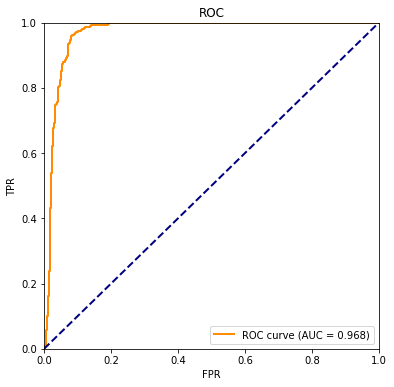

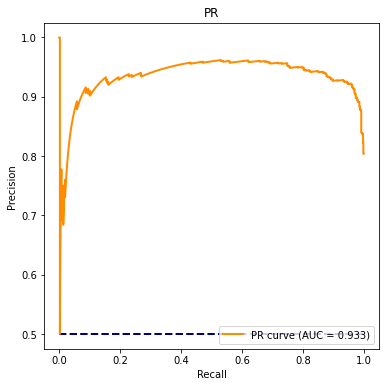

In [22]:
from sklearn.metrics import roc_curve, precision_recall_curve, auc

# Translate scores for ROC and PR curves
min_val = min(np.min(normal_elbos), np.min(anomalous_elbos))
max_val = max(np.max(normal_elbos), np.max(anomalous_elbos))
y_true_normal = np.zeros(normal_elbos.shape)
y_true_anomalous = np.ones(anomalous_elbos.shape)
y_true = np.concatenate((y_true_normal, y_true_anomalous))
y_score = (max_val - np.concatenate((normal_elbos, anomalous_elbos))) / (max_val - min_val)

# Compute ROC values
fpr, tpr, _ = roc_curve(y_true, y_score, drop_intermediate=True)
auroc = auc(fpr, tpr)

# Plot ROC curve
lw = 2
plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, color='darkorange',
          lw=lw, label=f'ROC curve (AUC = {str(auroc)[:5]})')
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC')
plt.legend(loc="lower right")
plt.show()

# Compute PR values
precision, recall, _ = precision_recall_curve(y_true, y_score)
auprc = auc(recall, precision)

# Plot PR curve
no_skill = len(y_true[y_true == 1]) / len(y_true)
plt.figure(figsize=(6, 6))
plt.plot([0, 1], [no_skill, no_skill], color="navy", lw=lw, linestyle='--')
plt.plot(recall, precision, color='darkorange',
          lw=lw, label=f'PR curve (AUC = {str(auprc)[:5]})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title("PR")
plt.legend(loc="lower right")
plt.show()